## Lab 1: CNN
Jonas Nockert, jonasnockert@gmail.com

Here, I will use Keras functional API to, first, construct a few smaller networks to examine the effects of batch normalization, data augmentation and regularization on classifying the fashion-MNIST dataset. Then I will extend/modify the MobileNetV2 network with corresponding pre-trained weights in order be able to train on and perform the same classification task. Finally, I will investigate visualizing convolutional layers in order to get a better feel for what it is the network is learning.

Note that I'm using Keras with PlaidML in order to be able to use an AMD Radeon graphics card for training in OSX.

In [1]:
from math import ceil
import os
import platform

import plaidml.keras

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras import backend as K
from keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from keras.datasets import fashion_mnist
from keras.layers import (
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
)
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

if platform.system() == "Darwin":
    import matplotlib

    matplotlib.use("MacOSX")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Set Seaborn plotting defaults.
sns.set()
sns.set_palette("RdBu")

Using plaidml.keras.backend backend.


In [2]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels = np.array([
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
])

### What does the Fashion MNIST dataset look like?

In [58]:
print("There are {:d} examples in the training set and {:d} in the test set.".format(
    len(train_labels), len(test_labels)))

print("The raw labels are {:s} ...".format(str(np.unique(train_labels))))
print("... which corresponds to labels {:s}".format(str(labels[np.unique(train_labels)])))

There are 60000 examples in the training set and 10000 in the test set.
The raw labels are [0 1 2 3 4 5 6 7 8 9] ...
... which corresponds to labels ['T-shirt/top' 'Trouser' 'Pullover' 'Dress' 'Coat' 'Sandal' 'Shirt'
 'Sneaker' 'Bag' 'Ankle boot']


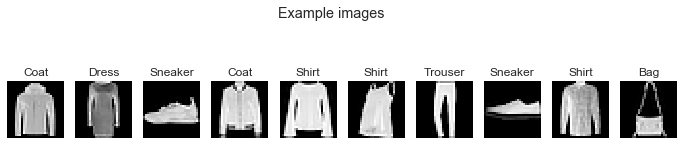

Text(0.5, 0.98, 'Distribution of categories')

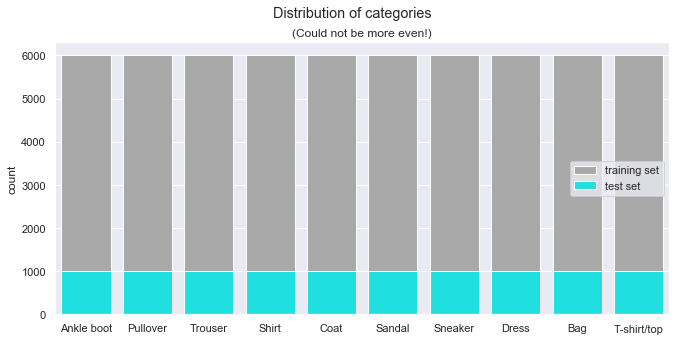

In [59]:
# Plot some example images.
fig = plt.figure(figsize=(12, 3))
indices = np.random.randint(0, len(train_labels), 10)
for i, index in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train_images[index], cmap="gray"), plt.axis("off")
    plt.title(labels[train_labels[index]])
fig.suptitle("Example images")
plt.show()

# Plot the distribution of categories.
fig = plt.figure(figsize=(11, 5))
sns.countplot(labels[train_labels[:]], color="darkgrey", label="training set");
plt.title("Very evenly distributed categories");
sns.countplot(labels[test_labels[:]], color="cyan", label="test set");
plt.title("(Could not be more even!)");
plt.legend(loc="center right");
fig.suptitle("Distribution of categories")

### Extract 10% of the training dataset to use as validation set
We will use the validation set to keep track of training performance, enabling us to leave the test set unseen until we are satisfied with the model. This way, we will avoid using the test set performance to guide hyperparameter tuning (and thus the risk of overfitting to the test set).

In [60]:
# Reshape from (60000, 28, 28) to (60000, 28, 28, 1), i.e. channels last format.
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# To be safe, it's best to permute the training set before splitting into two
# (validation, training), otherwise we might end up with unbalanced subsets
# (e.g. mostly nines in the validation set and few nines in the training set).
perm = np.random.permutation(len(train_images))
train_images = train_images[perm]
train_labels = train_labels[perm]
val_images = train_images[-6000:]
val_labels = train_labels[-6000:]
train_images = train_images[:-6000]
train_labels = train_labels[:-6000]

### Convolutional network model code
and configuration

In [105]:
class MnistModel:
    def __init__(self, image_size, config):
        self._input_shape = (image_size[0], image_size[1], 1)
        self.config = config

    def __call__(self):
        inputs = Input(shape=self._input_shape, name="img")

        x = Conv2D(
            32,
            kernel_size=(3, 3),
            kernel_initializer="he_normal",
            input_shape=self._input_shape,
            data_format="channels_last",
            name="cv1",
        )(inputs)
        x = Activation("relu", name="act1")(x)
        if self.config.batch_norm:
            x = BatchNormalization(name="bn1")(x)
        x = Conv2D(32, kernel_size=(3, 3), kernel_initializer="he_normal", name="cv2")(x)
        x = Activation("relu", name="act2")(x)
        if self.config.batch_norm:
            x = BatchNormalization(name="bn2")(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="mp1")(x)

        x = Conv2D(64, kernel_size=(3, 3), kernel_initializer="he_normal", padding="same", name="cv3")(x)
        x = Activation("relu", name="act3")(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="mp2")(x)
        if self.config.batch_norm:
            x = BatchNormalization(name="bn3")(x)

        x = Dropout(self.config.dropout1, name="drop1")(x)
        x = Flatten(name="flt")(x)
        x = Dense(self.config.dense_layer_size, name="dense1")(x)
        x = Activation("relu", name="act4")(x)
        x = Dropout(self.config.dropout2, name="drop2")(x)
        outputs = Dense(10, activation="softmax", name="out")(x)

        # With data augmentation, we should be able to use a lower dropout rate
        # (or none at all) as augmentation essentially increases the number of
        # training examples and thus counteracts overfitting.
        # https://arxiv.org/abs/1806.03852

        model = Model(inputs=inputs, outputs=outputs, name="model")
        return model

class Config:
    def __init__(
        self,
        learning_rate=1e-4,
        epochs=15,
        batch_size=32,
        seed=42,
        batch_norm=False,
        auto_reduce_learning_rate=True,
        dropout1=0.0,
        dropout2=0.0,
        dense_layer_size=128,
        augment_hflip=False,
        augment_vflip=False,
        augment_rotation=False,
        augment_shift=False,
        augment_shear=False,
        augment_zoom=False,
        model_path="fashion-mnist-model.h5",
    ):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.seed = seed
        self.batch_norm = batch_norm
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.dense_layer_size = dense_layer_size
        self.augment_hflip = augment_hflip
        self.augment_vflip = augment_vflip
        self.augment_rotation = augment_rotation
        self.augment_shift = augment_shift
        self.augment_shear = augment_shear
        self.augment_zoom = augment_zoom
        self.model_path=model_path
        self.auto_reduce_learning_rate=auto_reduce_learning_rate

In [122]:
def train(config, X, y, X_val, y_val, custom_model=None):
    augmentation_params = {}
    if config.augment_hflip:
        augmentation_params["horizontal_flip"] = True
    if config.augment_vflip:
        augmentation_params["vertical_flip"] = True
    if config.augment_rotation:
        augmentation_params["rotation_range"] = 10
    if config.augment_shift:
        augmentation_params["width_shift_range"] = 0.1
        augmentation_params["height_shift_range"] = 0.1
    if config.augment_shear:
        augmentation_params["shear_range"] = 0.1
    if config.augment_zoom:
        augmentation_params["zoom_range"] = 0.1

    # We can use image data generators to process images before they are
    # used for training or validation.
    train_datagen = ImageDataGenerator(
        dtype="float32",
        rescale=1.0 / 255,  # Use 0-1 floats rather than 0-255 ints.
        **augmentation_params,
    )

    # Note that we do not want to augment the validation set as we want it to
    # represent the same type of data as the test set.
    validation_datagen = ImageDataGenerator(dtype="float32", rescale=1.0 / 255)

    train_generator = train_datagen.flow(
        X, y, batch_size=config.batch_size, seed=config.seed
    )
    validation_generator = validation_datagen.flow(
        X_val, y_val, batch_size=config.batch_size, seed=config.seed
    )

    if custom_model:
        model = custom_model((32, 32), config)()
    else:
        model = MnistModel((28, 28), config)()

    model.compile(
        optimizer=Adam(lr=config.learning_rate),
        # Using the sparse variants lets us use one-hot encoded outputs
        # (i.e. the Dense(10) layer) from the model together with integer
        # 0-9 labels.
        loss=["sparse_categorical_crossentropy"],
        metrics=["sparse_categorical_accuracy"],
    )
    # Show information about the model we've built.
    model.count_params()
    model.summary()

    # If we only save the model after training we risk saving a model that's been
    # overfitted to the training data and not the "best" model we've seen during
    # training. Of course, the best model in this case is the one that gives the best
    # result on the (unseen) test data. Here we save the model that has the lowest
    # validation loss with the assumption that this is representative of the test set
    # data.
    checkpoint = ModelCheckpoint(
        "best-{}".format(config.model_path),
        save_weights_only=False,
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        mode="auto",
    )
    callbacks = [checkpoint]

    if config.auto_reduce_learning_rate:
        lr_reducer = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-5
        )
        callbacks.append(lr_reducer)
    
    history = model.fit_generator(
        train_generator,
        epochs=config.epochs,
        # Note that augmentation does not add samples but instead randomly augments
        # images. That is, we do not need to adjust parameters due to augmentation.
        steps_per_epoch=ceil(train_generator.n / config.batch_size),
        validation_data=validation_generator,
        validation_steps=ceil(validation_generator.n / config.batch_size),
        callbacks=callbacks,
        verbose=2,
        # use_multiprocessing=True,
    )

    # Save final model (not necessarily as good as the "best" model saved during
    # checkpoints.
    model.save(config.model_path)
    return model, history

In [73]:
def plot_results(history, title=None):
    acc = history.history["sparse_categorical_accuracy"]
    val_acc = history.history["val_sparse_categorical_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    print("---")
    print("Best accuracy: {:f} (trn, epoch {:d}), {:f} (val, epoch {:d})".format(
        np.max(acc),
        np.argmax(acc),
        np.max(val_acc),
        np.argmax(val_acc)
    ))
    print("Best loss: {:f} (trn, epoch {:d}), {:f} (val, epoch {:d})".format(
        np.min(loss),
        np.argmin(loss),
        np.min(val_loss),
        np.argmin(val_loss)
    ))

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(11, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "b--", label="Training")
    plt.plot(epochs, val_acc, "b", label="Validation")
    plt.axhline(y=0.9, color="green", linestyle="--")
    plt.title("Training and validation Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "r--", label="Training")
    plt.plot(epochs, val_loss, "r", label="Validation")
    plt.title("Training and validation loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    if title:
        fig.suptitle(title)
    plt.show()

In [126]:
def evaluate(model_path, X_test, y_test):
    # We rescaled to 0-1 floats in the image data generation phase and need
    # to do the same with the test images. Otherwise, the test set does not
    # represent the same type of data we've been training our model on.
    best_model = load_model("best-{}".format(model_path))
    results = best_model.evaluate(X_test / 255.0, y_test, verbose=0)
    print("Performance on test set for the \"best\" model seen during training:")
    print("-- accuracy: {:.3f}, loss: {:.3f}".format(results[1], results[0]))
    if results[1] > 0.9:
        print("😀 Kriteriet 90% rätt på testdata uppnått! 😅")

### Train model without batch normalization
No regularization or augmentation is used either.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
mp1 (MaxPooling2D)           (None, 12, 12, 32)        0         
_________________________________________________________________
cv3 (Conv2D)                 (None, 12, 12, 64)        18496     
__________

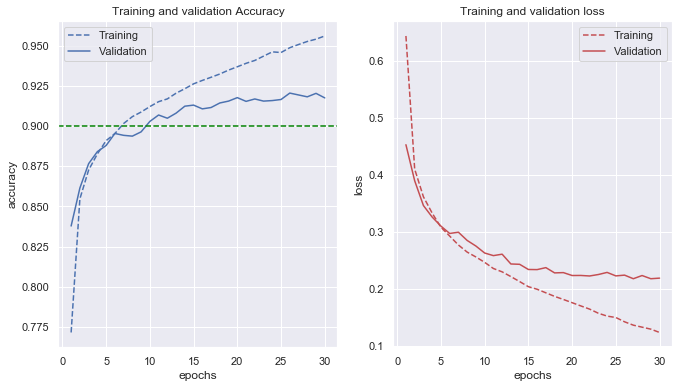

In [65]:
no_batch_norm_model_path="no-batch-norm-model.h5"
config = Config(
    epochs=30,
    batch_size=128,
    learning_rate=1e-4,
    model_path=no_batch_norm_model_path
)
np.random.seed(config.seed)
no_batch_norm_model, no_batch_norm_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(no_batch_norm_history, title="Without batch normalization")

#### Evaluate performance on test set

In [66]:
evaluate(no_batch_norm_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.912, loss: 0.250
😀 Kriteriet 90% rätt på testdata uppnått! 😅


#### Conclusion
Here, the model is overfitting to the training set and what the network ends up learning can't be expected to generalize. The performance gap between training and validation keeps increasing after >6 epochs, which is an indication that (a) there is potential for improving the performance of the model on the validation set (and thus the test set), and (b) we might benefit from introducing some form of regularization to make it a little harder for the network to learn the specifics of the training set.

Before adding regularization, lets see what happens if we perform batch normalization after every convolutional layer. There are many subleties but essentially, without batch normalization, the effects of changing an early layer's weights depends much on later layers' weights which makes the network difficult to optimize. With batch normalization, the effects are more controlled and training can be more effective. <https://blog.paperspace.com/busting-the-myths-about-batch-normalization/> <https://www.youtube.com/watch?v=Xogn6veSyxA>

### Train model with batch normalization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 24, 24, 32)        128       
__________

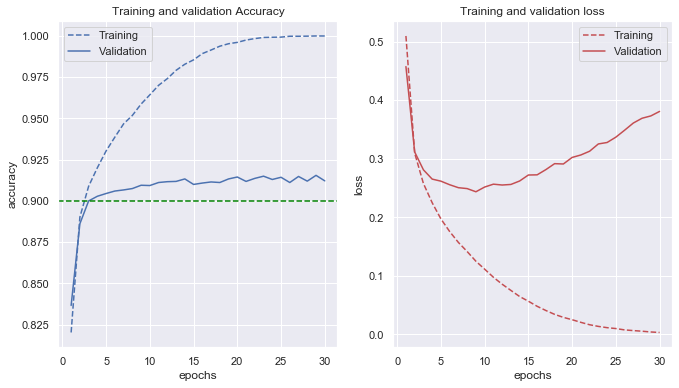

In [67]:
batch_norm_model_path="batch_norm_model.h5"
config = Config(
    epochs=30,
    learning_rate=1e-4,
    batch_size=128,
    batch_norm=True,
    model_path=batch_norm_model_path
)
np.random.seed(config.seed)
batch_norm_model, batch_norm_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(batch_norm_history, title="With batch normalization")

In [68]:
evaluate(batch_norm_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.910, loss: 0.258
😀 Kriteriet 90% rätt på testdata uppnått! 😅


#### Conclusion
The performance on the validation set is not much different but the curves are smoother and the learning is much more effective. After only about 3 epochs we reach >90% accuracy and it seems like we could increase the learning rate a bit without sacrificing stability. The validation loss ramps up as training loss decreases due to the model overfitting to the training data and not generalizing to the validation set.

The gap between training and validation sets are now substantial and we should try introducing regularization the network. Since we have batch norm in place, we can try augmentation as a way to virtually increase the number of training examples as an alternative means to explicitly regularizing the network through e.g. dropout. <https://arxiv.org/abs/1806.03852>
<https://arxiv.org/pdf/1502.03167.pdf>

### Train model with batch normalization and augmentation
Making no other changes to the hyperparameters.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 24, 24, 32)        128       
__________

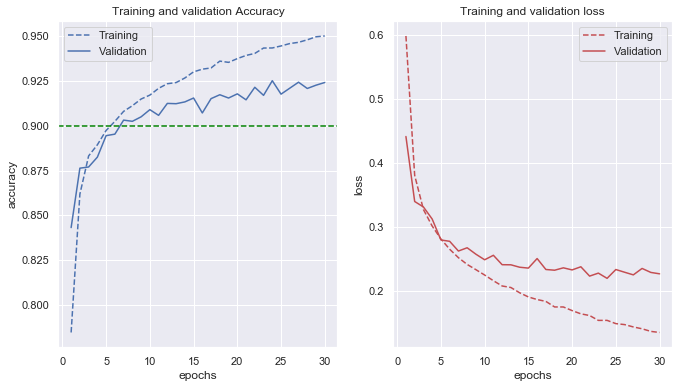

In [69]:
augm_model_path="augm-model.h5"
config = Config(
    epochs=30,
    learning_rate=1e-4,
    batch_size=128,
    batch_norm=True,
    augment_hflip=True,
    augment_zoom=0.1,
    model_path=augm_model_path
)
np.random.seed(config.seed)
augm_model, augm_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(augm_history, title="With batch normalization and augmentation")

In [70]:
evaluate(augm_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.915, loss: 0.249
😀 Kriteriet 90% rätt på testdata uppnått! 😅


### Train model with augmentation (and some dropout)
With data augmentation, we should be able to use a lower dropout rate
(or none at all) as augmentation essentially increases the number of
training examples and thus counteracts overfitting.
<https://arxiv.org/abs/1806.03852>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 24, 24, 32)        128       
__________

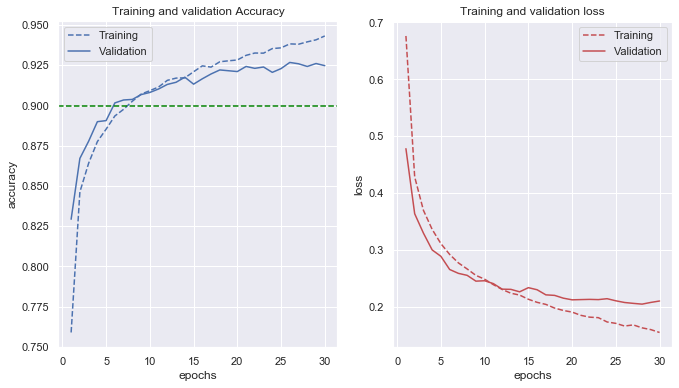

In [71]:
augm_dropout_model_path="augm-model.h5"
config = Config(
    epochs=30,
    learning_rate=1e-4,
    batch_size=128,
    batch_norm=True,
    dropout1=0.05,
    dropout2=0.1,
    augment_hflip=True,
    augment_zoom=0.1,
    model_path=augm_dropout_model_path
)
np.random.seed(config.seed)
augm_dropout_model, augm_dropout_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(augm_dropout_history, title="With batch normalization, augmentation and dropout")

In [72]:
evaluate(augm_dropout_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.918, loss: 0.232
😀 Kriteriet 90% rätt på testdata uppnått! 😅


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 24, 24, 32)        128       
__________

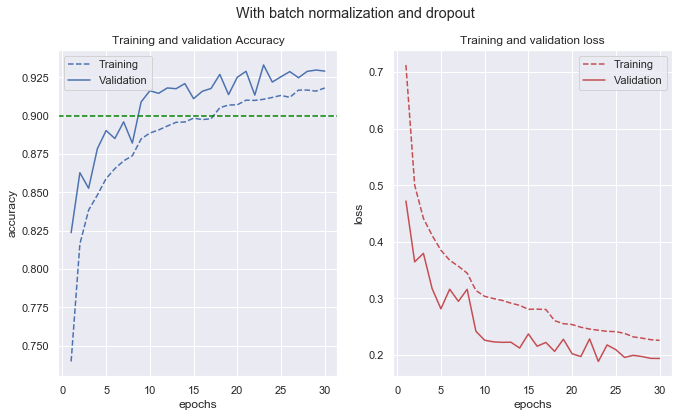

In [89]:
dropout_model_path="dropout-model.h5"
config = Config(
    epochs=30,
    learning_rate=5e-3,
    batch_size=128,
    batch_norm=True,
    dropout1=0.1,
    dropout2=0.3,
    augment_hflip=True,
    augment_zoom=0.05,
    augment_rotation=5,
    augment_shift=0.05,
    model_path=dropout_model_path
)
np.random.seed(config.seed)
dropout_model, dropout_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(dropout_history, title="With batch normalization and dropout")

In [97]:
evaluate(dropout_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.922, loss: 0.215
😀 Kriteriet 90% rätt på testdata uppnått! 😅


### Transfer learning
We will use MobileNetV2 with pre-trained weights from ImageNet. ImageNet is a *huge* dataset consisting of a wide range of images, which is not a particularly good match with the fashion-MNIST dataset. Had the datasets been similar enough we could have just fine-tuned our model, i.e. trained only the weights of the top layers rather than the whole network.
With transfer learning we start with weights that are honed in on extracting features for good classification results on ImageNet — and our hope is that the same features will be useful in the current classification task.

Our dataset consists of 28x28 grayscale images and MobileNetV2 only accepts larger RGB images so we need to resize/pad our images as well as make them 3-channel RGB. Now, I'm not sure about how it works under the hood but MobileNetV2 accepts 32x32x3 inputs, which is pretty close to what we have. However, there are no weights available for that shape (96x96x3 is the closest choice) so the question is if we would be better off padding/resizing to 96x96 and using matching weights? The network will take much longer to train this way and our padded/resized images will likely be a poor match with these weights anyway.

If we go with 32x32x3 inputs, as I understand it, weights from the 224x224x3 network layers will be loaded into layers with matching names. I'm assuming this will be layers closer to the top, where the weights are based on the feature extraction done during previous convolutional layers. Will these weights be at all useful here or will we just re-train the entire network ending up with weights very far from the starting point? Might this even hurt performance and would we instead be better off starting with a good random initialization?

I'll save these questions for a rainy day and go with the smaller network and faster training time.

Oh, why MobileNetV2? It's a relatively small network that performs well on mobile devices and mobile computer vision and machine learning is something I've been interested in for a long time so I just wanted to try it out.

In [120]:
class MnistTransferModel:
    def __init__(self, image_size, config):
        self._input_shape = (image_size[0], image_size[1], 3)
        self.config = config
        
    def __call__(self):
        from keras.applications.mobilenet_v2 import MobileNetV2

        inputs = Input(shape=self._input_shape, name="img")
        net = MobileNetV2(
            # Shape is actually inferred from the `input_tensor` but should
            # we want to use 96x96x3 images, we need to provide `input_shape`
            # in order to use the most appropriate weights: 96 instead of 224.
            input_shape=self._input_shape,
            input_tensor=inputs,
            alpha=1.0,
            include_top=False,
            weights="imagenet",
            pooling=None
        )
        x = Flatten(name="flt")(net.output)
        x = Dense(self.config.dense_layer_size, name="dense1")(x)
        x = Activation("relu", name="act4")(x)
        x = Dropout(self.config.dropout1, name="drop1")(x)
        outputs = Dense(10, activation="softmax", name="out")(x)

        model = Model(inputs=inputs, outputs=outputs, name="model")
        return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           img[0][0]                        
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

INFO:plaidml:Analyzing Ops: 1871 of 5734 operations complete
INFO:plaidml:Analyzing Ops: 3840 of 5734 operations complete
INFO:plaidml:Analyzing Ops: 1401 of 5734 operations complete
INFO:plaidml:Analyzing Ops: 3186 of 5734 operations complete


 - 149s - loss: 0.5328 - sparse_categorical_accuracy: 0.8192 - val_loss: 7.5777 - val_sparse_categorical_accuracy: 0.1732

Epoch 00001: val_loss improved from inf to 7.57773, saving model to best-transfer-model.h5
Epoch 2/20
 - 105s - loss: 0.3310 - sparse_categorical_accuracy: 0.8859 - val_loss: 0.5619 - val_sparse_categorical_accuracy: 0.8175

Epoch 00002: val_loss improved from 7.57773 to 0.56189, saving model to best-transfer-model.h5
Epoch 3/20
 - 103s - loss: 0.2967 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.7817 - val_sparse_categorical_accuracy: 0.7585

Epoch 00003: val_loss did not improve from 0.56189
Epoch 4/20
 - 104s - loss: 0.2625 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.4716 - val_sparse_categorical_accuracy: 0.8650

Epoch 00004: val_loss improved from 0.56189 to 0.47156, saving model to best-transfer-model.h5
Epoch 5/20
 - 105s - loss: 0.2517 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.6327 - val_sparse_categorical_accuracy: 0.8383

Epoch 000

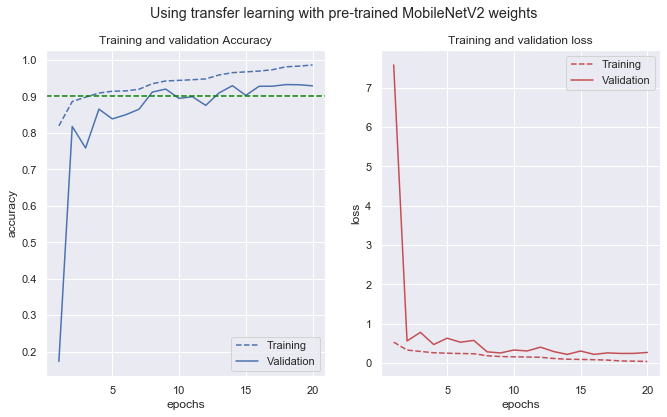

In [123]:
# Pad images with zeros to form 32x32 images as this is the smallest size
# most pre-trained networks in Keras accepts.
padding = (2, 2)
train_images_padded = np.pad(train_images, ((0, 0), padding, padding, (0, 0)), "constant")
val_images_padded = np.pad(val_images, ((0, 0), padding, padding, (0, 0)), "constant")
test_images_padded = np.pad(test_images, ((0, 0), padding, padding, (0, 0)), "constant")

# Stack 3 x grayscale images to form 3-channel "RGB" images as this is what
# pre-trained networks expect.
train_images_padded = np.squeeze(np.stack([train_images_padded] * 3, axis=-1))
val_images_padded = np.squeeze(np.stack([val_images_padded] * 3, axis=-1))
test_images_padded = np.squeeze(np.stack([test_images_padded] * 3, axis=-1))

transfer_model_path="transfer-model.h5"
config = Config(
    epochs=20,
    learning_rate=1e-3,
    batch_size=64,
    # dropout1=0.25,
    model_path=transfer_model_path
)
np.random.seed(config.seed)
transfer_model, transfer_history = train(
    config,
    train_images_padded,
    train_labels,
    val_images_padded,
    val_labels,
    custom_model=MnistTransferModel
)
plot_results(transfer_history, title="Using transfer learning with pre-trained MobileNetV2 weights")

In [127]:
evaluate(transfer_model_path, test_images_padded, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.923, loss: 0.242
😀 Kriteriet 90% rätt på testdata uppnått! 😅


### Visualizing what convolutional networks learn

#### Visualizing intermediate activations

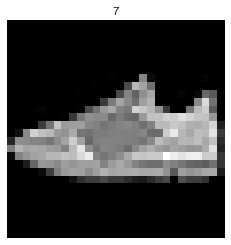

In [154]:
# Get random image from test set (unseen during model training)
ix = np.random.randint(len(test_labels))
plt.figure()
plt.imshow(test_images[ix].reshape((28, 28)), cmap="gray"), plt.axis("off")
plt.title(test_labels[ix])
plt.show()

(1, 26, 26, 32)


/Users/lemonad/.local/share/virtualenvs/Deep_Learning_HT19-O0LExEKV/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


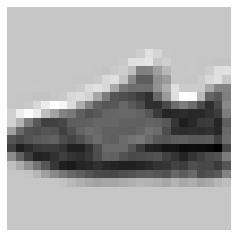

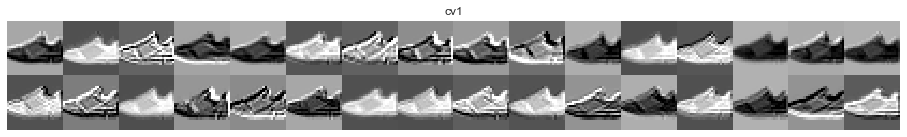

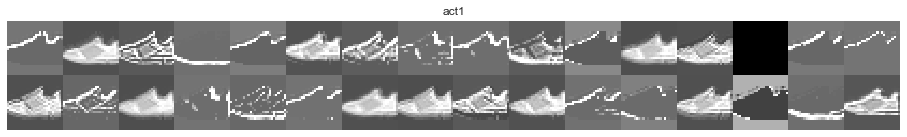

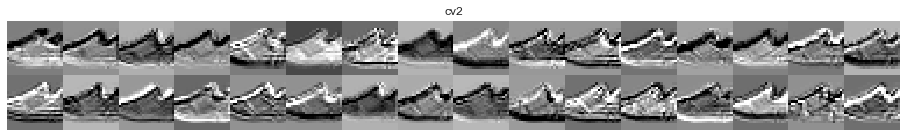

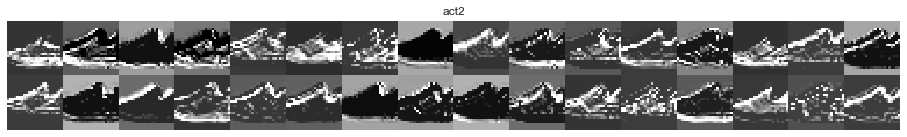

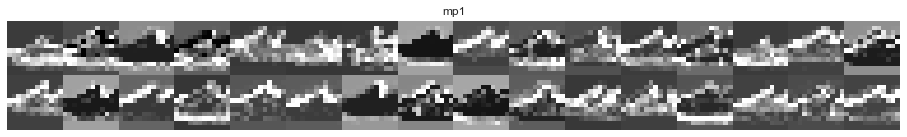

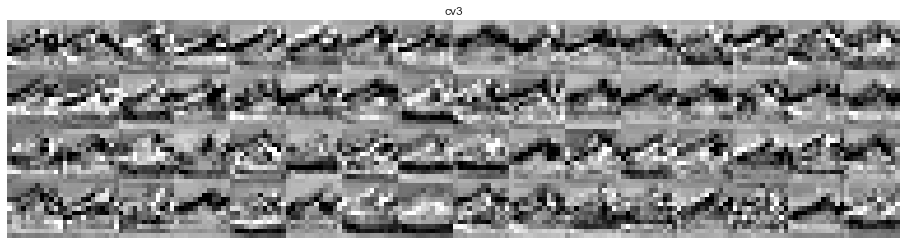

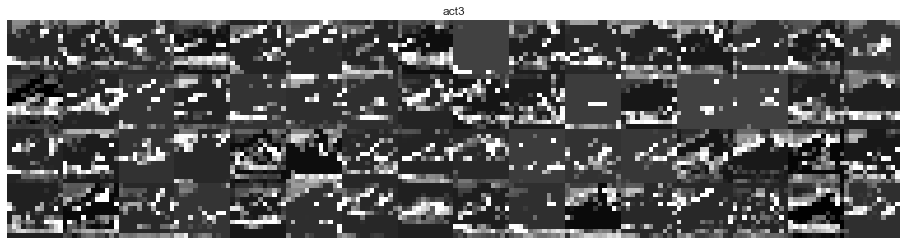

In [160]:
best_model = load_model("best-{:s}".format(augm_dropout_model_path))

# Extract the convolutional and activation layers.
relevant_layers = [1, 2, 4, 5, 7, 8, 9]
layer_outputs = [best_model.layers[i].output for i in relevant_layers]
# Create a multi-output model, one for each relevant layer.
activation_model = Model(inputs=best_model.input, outputs=layer_outputs)
# Run the random image from above through the model so we get the
# outputs.
activations = activation_model.predict(test_images[ix].reshape((1, 28, 28, 1)) / 255.0)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 4], cmap="gray"), plt.axis("off")

layer_names = []
for i in relevant_layers:
    layer_names.append(best_model.layers[i].name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray'), plt.axis("off")

The activations convolutional network